# SAH Foils CNN

The overall sequence is:

### Train a first version the NN with a reduced FOV so that it can train quickly and on more images.
- Get a bunch of names of images from original tifs.
- Split them into Train/Val/Test splits, crop and norm the images, and put them into N_FOVxFOV/Craters.HDF.  (N is the number of images, FOV is the field of view in pixels.)
- Train on the reduced FOV images.  Should be able to achieve 0.998 val accuracy using about 4000 images, 150x150 FOV, and about 600 epochs.

### Transfer train a CNN with full images (384x512 pixels).
- Get a bunch of image names from the foils database on Flair for frames that dusters say do have craters.
- Get a bunch of image names from the foils database on Flair for frames that dusters say do not have craters.
- Download those images from amazon (can take a long time).
- Split them into Train/Val/Test splits, norm the images, and put them into N_FOVxFOV/Craters.HDF.  (N is the number of images, FOV is the field of view in pixels.)
- Copy the network weights over from the reduced FOV CNN.
- Retrain.


## Get a bunch of names of images from the foils database on Flair so we have images to work with.

You have to do this from within SSL or via VPN.  Get a list of file names using a select statement on the Stardust database (which is live raw data).  We will use this 20k list for predicting.

`SELECT amazon_key FROM real_movie WHERE exclude = '' AND comment = '' AND tech = 0 AND bad_focus < 50 LIMIT 20000`  
exclude = '' because ?  
comment = '' because ?  
tech = 0 means that this is not a calibration crater (i.e. it is in all liklihood a blank foil image.)

You should wind up with a file named `amazon20k.txt` in your data directory which should look like this:

amazon_key  
fm_-112786_-69214  
fm_18704_42676  
fm_27254_42676  
fm_39404_42056  
fm_40304_33686  
fm_11305_7266  
fm_12703_6956  
fm_13550_10986  
fm_15344_22146  
fm_16805_10676  
...

While we are at it let's also get image names for the full view images for training:

`SELECT amazon_key FROM real_movie WHERE tech = 1 and conf > 5 AND disconf < 3 AND bad_focus < 50 LIMIT 10000`
tech = 1 means we want it to have a calibration crater in it.
conf > 5 means at least 5 dusters have confirmed a crater is present.
disconf < 3 means fewer than 3 dusters have labeled this as not having a crater
badfocus < 50 means no more than 50 dusters said the focus was bad in this image.
Store this in `amazon_hascraters.txt`
  
 `SELECT amazon_key FROM real_movie WHERE tech = 0 and disconf > 5 AND conf < 3 AND bad_focus < 50 LIMIT 10000`
 Just the same but tech = 0
 Store this in `amazon_nocraters.txt`
 
 This step can be done with the `001-CollectAmazonCodes.py` file or just log in to the MySQL server using SQLectron and save the results to the text files.
 

## Download those images from amazon (can take a long time due to bandwith throttling at their end.)

This is done using `002-CollectImages.py`

Change the fname to `amazon3k.txt` or whatever your list of filenames is.
Change the save_f_base to the name you want for an hdf file.

Repeat for all the files downloaded in the last step:

For the reduced FOV CNN:  
The reduced FOVS are produced from the RawData/(foilname) directories.  So there is no need to pull images from Amazon right now.  
<!---
amazon2k_hascraters.txt &rarr; amazon2k_hascraters.hdf5  (will become Train/Val/Test true)  
amazon2k_nocraters.txt &rarr; amazon2k_nocraters.hdf5  (will become Train/Val/Test false)
--->

For the full FOV CNN:  
amazon3k_nocraters.txt &rarr; amazon2k_FullFOV_no.hdf5  
amazon3k_yescraters.txt &rarr; amazon2k_FullFOV_yes.hdf5  (also change start number to 2000 so it isn't the same images as the last.)  


In [ ]:
# First 10000 blank images to a local directory.
# Note for some reason parallel doesn't run well inside the notebook.  I suggest you drop it into a terminal.
!parallel --jobs 20 -n 0 "python 003-CollectImagesToDir.py --AmazonFileName ../Data/amazon10k_nocraters.txt --SaveDirName ../Data/amazon10k_nocraters --Shuffle True" ::: {1..20}

In [ ]:
# Pack those into an HDF.
!python 004-ImagesDirToHDF.py --ImagesDir ../Data/amazon10k_nocraters --HDFName ../Data/amazon10k_FullFOV_nocraters

In [8]:
# First 10000 blank images to a local directory which will (later) have craters dubbed in.
# Note for some reason parallel doesn't run well inside the notebook.  I suggest you drop it into a terminal.
!parallel --jobs 20 -n 0 "python 003-CollectImagesToDir.py --AmazonFileName ../Data/amazon10k_yescraters.txt --SaveDirName ../Data/amazon10k_yescraters --Shuffle True" ::: {1..20}

In [7]:
# Pack those into an HDF.
!python 004-ImagesDirToHDF.py --ImagesDir '../Data/amazon10k_yescraters' --HDFName '../Data/amazon10k_FullFOV_yescraters'

In [3]:
# Older method.  This doesn't work when you get into the range of 10000 images.
# Images without craters for making the Train/Val/Test for full FOV CNN.
#!python 002-CollectImages.py --txtfile amazon3k_nocraters.txt --hdffile amazon2k_FullFOV_no --step_size 3000 --start_number 0

In [4]:
# Older method.  This doesn't work when you get into the range of 10000 images.
# Images with craters for making the Train/Val/Test for full FOV CNN.
#!python 002-CollectImages.py --txtfile amazon3k_yescraters.txt --hdffile amazon2k_FullFOV_yes --step_size 3000 --start_number 0

# Generate Train/Val/Test split HDFs.

Split them into Train/Val/Test splits, crop and norm the images, and put them into N_FOVxFOV/Craters.HDF

We can fit a total size of about 4000 images in the GPU using a 150x150 FOV and this gives us a high accuracy while being relatively quick to train.  In this case the images come from the stored tif files on our disk and the crater images are dubbed in.

This is done with `010-PreprocessReducedFOV.py`

In [2]:
%%bash
#python 010-PreprocessReducedFOV.py
echo Moving files to desination directories.
mkdir ../Data/10000_150x150
mv ../Data/Craters_normed.hdf5 ../Data/10000_150x150/Craters.hdf5
rm ../Data/Craters.hdf5

Moving files to desination directories.


mkdir: cannot create directory ‘../Data/10000_150x150’: File exists


Next we produce splits for the full FOV training from `amazon2k_FullFOV_yes.hdf5` and `amazon2k_FullFOV_no.hdf5`.

This is done with `011-PreprocessFullFOV.py`

In [3]:
%%bash
python 011-PreprocessFullFOV.py
rm ../Data/10000_384x512/Craters.hdf5
mv ../Data/10000_384x512/Craters_normed.hdf5 ../Data/10000_384x512/Craters.hdf5

Input Yes File: ../Data/amazon2k_FullFOV_yes.hdf5
Input No File: ../Data/amazon2k_FullFOV_no.hdf5
Output Combined File: ../Data/1000_384x512/Craters.hdf5
Splitting Yes set into Train/Val/Test.
Writing TrainYes
Writing ValYes
Writing TestYes
Writing TrainNo
Writing ValNo
Writing TrainNo
['Unspecified foil number(s).']
Writing normed dataset to: ../Data/1000_384x512/Craters_normed.hdf5
Norming TrainYes
Norming TrainNo
Norming TestYes
Norming TestNo
Norming ValYes
Norming ValNo
normed 

!!!!!!!!!!!!!!!!!!!
Time to run: 0:03:16.410220
all done
!!!!!!!!!!!!!!!!!!!


# Train on the reduced FOV images. 

Should be able to achieve 0.998 val accuracy using about 4000 images, 150x150 FOV, and about 600 epochs.

In [1]:
%load_ext tensorboard
%tensorboard --logdir ../Data/10000_150x150/TB

This is just a static screen shot of tensorboard for reference.

![](10000_150x150screenshot.png)

In [ ]:
!python 020-Best150_mid_2.py

/home/zack/anaconda3/envs/tf1x/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zack/anaconda3/envs/tf1x/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zack/anaconda3/envs/tf1x/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zack/anaconda3/envs/tf1x/lib/python3.7/site-packages

# Transfer weights and train Full FOV network.

Using only 500 images (since the full 1000 doesn't fit in my RTX 2060) we get to 0.996 ValAcc.

In [5]:
!cp ../Data/10000_150x150/NFP_acc_FOV\[150\ 150\].h5 ../Data/10000_384x512/NFP_acc_FOV\[150\ 150\].h5 

In [5]:
%load_ext tensorboard
%tensorboard --logdir ../Data/10000_384x512/TB

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 8454), started 0:02:44 ago. (Use '!kill 8454' to kill it.)

This is just a static screen shot of tensorboard for reference.

![](10000_384x512screenshot.png)

In [2]:
!python 021-384x512.py

/home/zack/anaconda3/envs/tf1x/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zack/anaconda3/envs/tf1x/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zack/anaconda3/envs/tf1x/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zack/anaconda3/envs/tf1x/lib/python3.7/site-packages

# Use the trained Full FOV network to predict whether images have craters.

The easiest pipeline is to read one image at a time from disk and evaluate it.  Then produce an output file with the yes/no results.

### A quick trivial example.  

I've downloaded two images into Data/Predict/amazonimages.  One is a crater training image and one is not.

In [22]:
# Run the prediction using the FullFOV network.
!python 030-384x512Predict.py --PredictDir '../../RawData/AmazonDatabase/RealImages' --PredictionsOutputFile '../../RawData/AmazonDatabase/RealImages_predictions.csv' --Extension 'jpg' --ModelFile '../Data/10000_384x512/NFP_actual_acc.h5' --Verbose False
!python 031-MakeViewPredictionsHTML.py --PredictionsFile '../../RawData/AmazonDatabase/RealImages_predictions.csv' --PredictionsFileHTML '../../RawData/AmazonDatabase/RealImages_predictions.html' --RelativePath 'RealImages'

Using TensorFlow backend.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Predicting 2 images from ../Data/Predict/amazonimages.
..
Predictions written to: ../Data/Predict/amazonimages_predictions.csv.
Done!
../Data/Predict/amazonimages_predictions.csv
Wrote predictions output to /mnt/9CA8C68DA8C6657C/SAH/Foils/FoilsV2/Code/../Data/Predict/amazonimages_predictions.html
(Copy and paste that into a new tab to view.)
Done


At this point you can do varius manipulations of the data to see extract useful stuff from it.  Here we're going to sync the predictions up with the real_movies table so we can produce an output html which only includes predictions > 0.1, does not have bad focus, and so that the html can also include the VM number so we can link it up with the spreadsheet that NRL uses.  This is a condensed example from MergePredictionsWith_real_movie.ipynb and assumes you already ran the predictions on 400k images and saved it as AmazonDatabase_predictions.csv.

,id,num_frames,mscore,mscore2,when_created,status,comment,file_comment,conf,disconf,...,tech,bad_focus,x_coord,y_coord,frame,xymag,zmag,VMcode,Prediction,FileName
76334,5563734,1,-1.7,-2,2015-11-24 15:23:19,0,NaN,real I1126N 541 2 0,1,3,...,0,0,0,0,0,0,0,7979425V1,5.241653e-08,../../RawData/AmazonDatabase/RealImages/fc_000...


424568 images are included in the untrimmed set.
14939 images are included in the trimmed set.
../../RawData/AmazonDatabase/RealImages_predictionsTrimmed.csv
Wrote predictions output to /mnt/9CA8C68DA8C6657C/SAH/Foils/FoilsV3/Code/../../RawData/AmazonDatabase/RealImages_predictionsTrimmed.html
(Copy and paste that into a new tab to view.)
Done


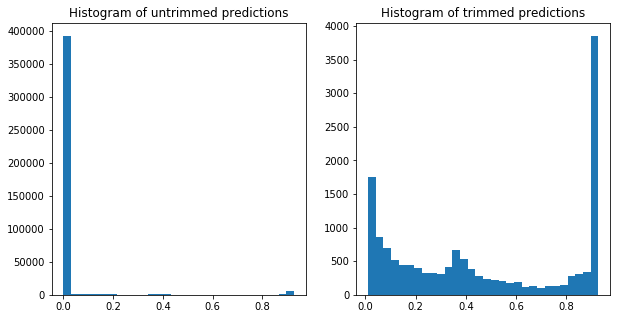

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

#Load the predictions made on the entire amazon database.
Pred = pd.read_csv('../../RawData/AmazonDatabase/RealImages_predictions.csv')
# Make a new column which is just the amazon_key so we can merge it with the full real_movie table
Pred['amazon_key'] = Pred.FileName.apply(lambda x: os.path.split(x)[-1]) # Get just the filename.
Pred.amazon_key = Pred.amazon_key.apply(lambda x: os.path.splitext(x)[0])

# Load the real_movie table.
Real = pd.read_csv('../../RawData/AmazonDatabase/real_movie.csv')

# Combine them both into a new table.
PredReal = Real.join(Pred.set_index('amazon_key'), on='amazon_key')

# And print out one record just to see that it is working.
display(PredReal[PredReal['amazon_key'] == 'fc_0009B8MmpmMmazxkRHRU.21333'])

# Histogram the predictions.
fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(PredReal.Prediction,bins=30)
ax[0].set_title('Histogram of untrimmed predictions')
print(f'{PredReal.shape[0]} images are included in the untrimmed set.')

# Trim the predictions to get only the best and no bad_focus.
PredReal = PredReal.query('Prediction > 0.01 and bad_focus == 0')

# Histogram the trimmed predictions.
print(f'{PredReal.shape[0]} images are included in the trimmed set.')
ax[1].hist(PredReal.Prediction,bins=30)
ax[1].set_title('Histogram of trimmed predictions')

# Save it to a new csv.
PredReal.to_csv('../../RawData/AmazonDatabase/RealImages_predictionsTrimmed.csv')
PredReal.sort_values('Prediction').to_csv('../../RawData/AmazonDatabase/RealImages_predictionsTrimmedForFlair.csv', columns=['Prediction','FileName','amazon_key'], index_label='id')

# Make an output HTML to view the predictions sorted by most likely at the top.
!python 031-MakeViewPredictionsHTML.py --PredictionsFile '../../RawData/AmazonDatabase/RealImages_predictionsTrimmed.csv' --PredictionsFileHTML '../../RawData/AmazonDatabase/RealImages_predictionsTrimmed.html' --RelativePath 'RealImages'

## Updating Flair.

In order to update Flair, you have to upload the "...forFlair.csv" to flair and then use the SQL client there in order to update records.  There are a couple updates that will have to happen.

1) For all records with id>5500000, change the prediction column from null to 0.  (Leave 5000000 - 5499999 null)  
&nbsp;&nbsp;&nbsp;&nbsp; UPDATE real_movie_v3 SET PredictionV3 = 0.0 WHERE id >= 5500000  
2) For all records with in the csv, update the prediction column to have whatever the correct prediction is.  
3) We don't change the rest of the records (those with prediction = 0) and that saves a boatload of time.


### Predict based on a pile of images from Amazon.

In [4]:
# Get a bunch of images from amazon.
!python 003-CollectImagesToDir.py --AmazonFileName '../Data/Amazon20k.txt' --SaveDirName '../Data/Predict/amazon20k'

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [4]:
# Run the prediction using the FullFOV network.
!python 030-384x512Predict.py --PredictDir '../Data/Predict/amazon20k' --PredictionsOutputFile '../Data/Predict/amazon20k_predictions.csv' --Extension 'jpg' --ModelFile '../Data/1000_384x512/NFP_actual_acc.h5' --Verbose False

In [21]:
# Make an output HTML to view the predictions sorted by most likely at the top.
!python 031-MakeViewPredictionsHTML.py --PredictionsFile '../Data/Predict/amazon20k_predictions.csv' --PredictionsFileHTML '../Data/Predict/amazon20k_predictions.html' --RelativePath 'amazon20k'

../Data/Predict/amazon20k_predictions.csv
Wrote predictions output to /mnt/9CA8C68DA8C6657C/SAH/Foils/FoilsV2/Code/../Data/Predict/amazon20k_predictions.html
(Copy and paste that into a new tab to view.)
Done


### We can also run this directly on raw images with a 768x1024 resolution.  

This doesn't work very well because it wasn't trained on this size, and also these are tifs so the training is actually expecting to see the jpg artifacts.  But in principle it works, and we could consider doing another training step on the final tifs in order to spiffy it up.  We'd need a GPU with lots of RAM though.

In [27]:
!python 030-384x512Predict.py --PredictDir '../Data/Predict/I1009N' --PredictionsOutputFile '../Data/Predict/I1009N_predictions.csv' --Extension 'TIF' --ModelFile '../Data/1000_384x512/NFP_actual_acc.h5' --Verbose False

Using TensorFlow backend.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Predicting 14283 images from ../Data/Predict/I1009N.
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [28]:
# Make an output HTML to view the predictions sorted by most likely at the top.
!python 031-MakeViewPredictionsHTML.py --PredictionsFile '../Data/Predict/I1009N_predictions.csv' --PredictionsFileHTML '../Data/Predict/I1009N_predictions.html' --RelativePath 'I1009N'

../Data/Predict/I1009N_predictions.csv
Wrote predictions output to /mnt/9CA8C68DA8C6657C/SAH/Foils/FoilsV2/Code/../Data/Predict/I1009N_predictions.html
(Copy and paste that into a new tab to view.)
Done
